In [1]:
import os
import glob
import pyart
import numpy as np
import pandas as pd
import xarray as xr
import pyscancf as pcf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## Cite PyScanCf:

## Syed, H. A.,Sayyed, I., Kalapureddy, M. C. R., & Grandhi, K. K.(2021). 
## PyScanCf – The library for individual sweep datasets of IMD weather radars. 
## Zenodo. doi:10.5281/zenodo.5574160.



In [2]:
pcf.__version__

'1.0.29'

In [3]:
# Load the gridded data
grid_files = sorted(glob.glob("../CURAJ/IMD_Kolkata/output_directory/grid*.nc"))
len(grid_files)

53

In [4]:
# Check if the loaded files are what we want (only three for our convenience)
grid_files[:3]

['../CURAJ/IMD_Kolkata/output_directory/grid_CAL220430112010-IMD-C.nc',
 '../CURAJ/IMD_Kolkata/output_directory/grid_CAL220430112232-IMD-C.nc',
 '../CURAJ/IMD_Kolkata/output_directory/grid_CAL220430113000-IMD-C.nc']

In [5]:
ref_list = []
for file in grid_files:
    grid = pyart.io.read_grid(file)
    xarray_grid = grid.to_xarray()
    # Since, we want to work with QPE only,
    # we will only use only Reflectivity for now,
    # and that too at only one level
    ref = xarray_grid['REF'].sel(z=1000, method='nearest')
    ref_list.append(ref)

ds = xr.concat(ref_list, dim='time').to_dataset()

In [6]:
ds

<xarray.Dataset> Size: 57MB
Dimensions:  (time: 53, y: 500, x: 500)
Coordinates:
  * time     (time) object 424B 2022-04-30 11:20:10 ... 2022-04-30 18:12:06
    z        float64 8B 1.067e+03
    lat      (y, x) float64 2MB 20.3 20.3 20.3 20.31 ... 24.8 24.8 24.8 24.8
    lon      (y, x) float64 2MB 85.96 85.97 85.98 85.99 ... 90.81 90.82 90.83
  * y        (y) float64 4kB -2.5e+05 -2.49e+05 -2.48e+05 ... 2.49e+05 2.5e+05
  * x        (x) float64 4kB -2.5e+05 -2.49e+05 -2.48e+05 ... 2.49e+05 2.5e+05
Data variables:
    REF      (time, y, x) float32 53MB 13.85 13.83 13.85 13.84 ... nan nan nan

In [7]:
# Merge the data into one file, and export it to netcdf, we can directly use the same file later
# ds.to_netcdf('kol_merged_reflectivity.nc')

In [8]:
def rain_rate_ds(ds, var='REF', a=200, b=1.6, rr_name='rain_rate'):
    def _rain_rate(dbz, a=200.0, b=1.6):
        """Calculates the inverse of input decibel values
        Convert to rain rate using Marshall Palmer Relation
        """
        Z = 10.0 ** (dbz / 10.0)
        return  (Z / a) ** (1.0 / b)
    R = _rain_rate(dbz=ds[var], a=a, b=b)
    R.attrs['units'] = "mm/h"
    ds[rr_name] = R
    
    return ds

In [9]:
ds = xr.open_dataset("kol_merged_reflectivity.nc", use_cftime=True)

In [10]:
ds = rain_rate_ds(ds, var='REF', a=200, b=5, rr_name='rain_rate')

In [11]:
ts = ds['rain_rate'].mean(['x', 'y']).resample(time='30min', label='right').mean().interpolate_na('time')
# ts['time'] = pd.to_datetime(ts['time'].values).round('S')

In [12]:
print(ts['time'].dtype)

object


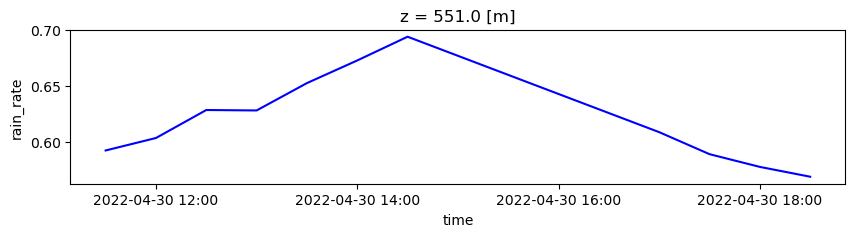

In [13]:
ts.plot.line('b-', figsize=[10, 2])

In [14]:
## download ERA5 data for comparison

In [15]:
ts.time.min().values, ts.time.max().values

(array(cftime.DatetimeGregorian(2022, 4, 30, 11, 30, 0, 0, has_year_zero=False),
       dtype=object),
 array(cftime.DatetimeGregorian(2022, 4, 30, 18, 30, 0, 0, has_year_zero=False),
       dtype=object))

In [16]:
ds.lon.min().values, ds.lat.min().values, ds.lon.max().values, ds.lat.max().values

(array(85.87679296),
 array(20.30471417),
 array(90.82920306),
 array(24.81880323))

Download GPM IMERG data from https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_07/summary?keywords=%22IMERG%20final%22

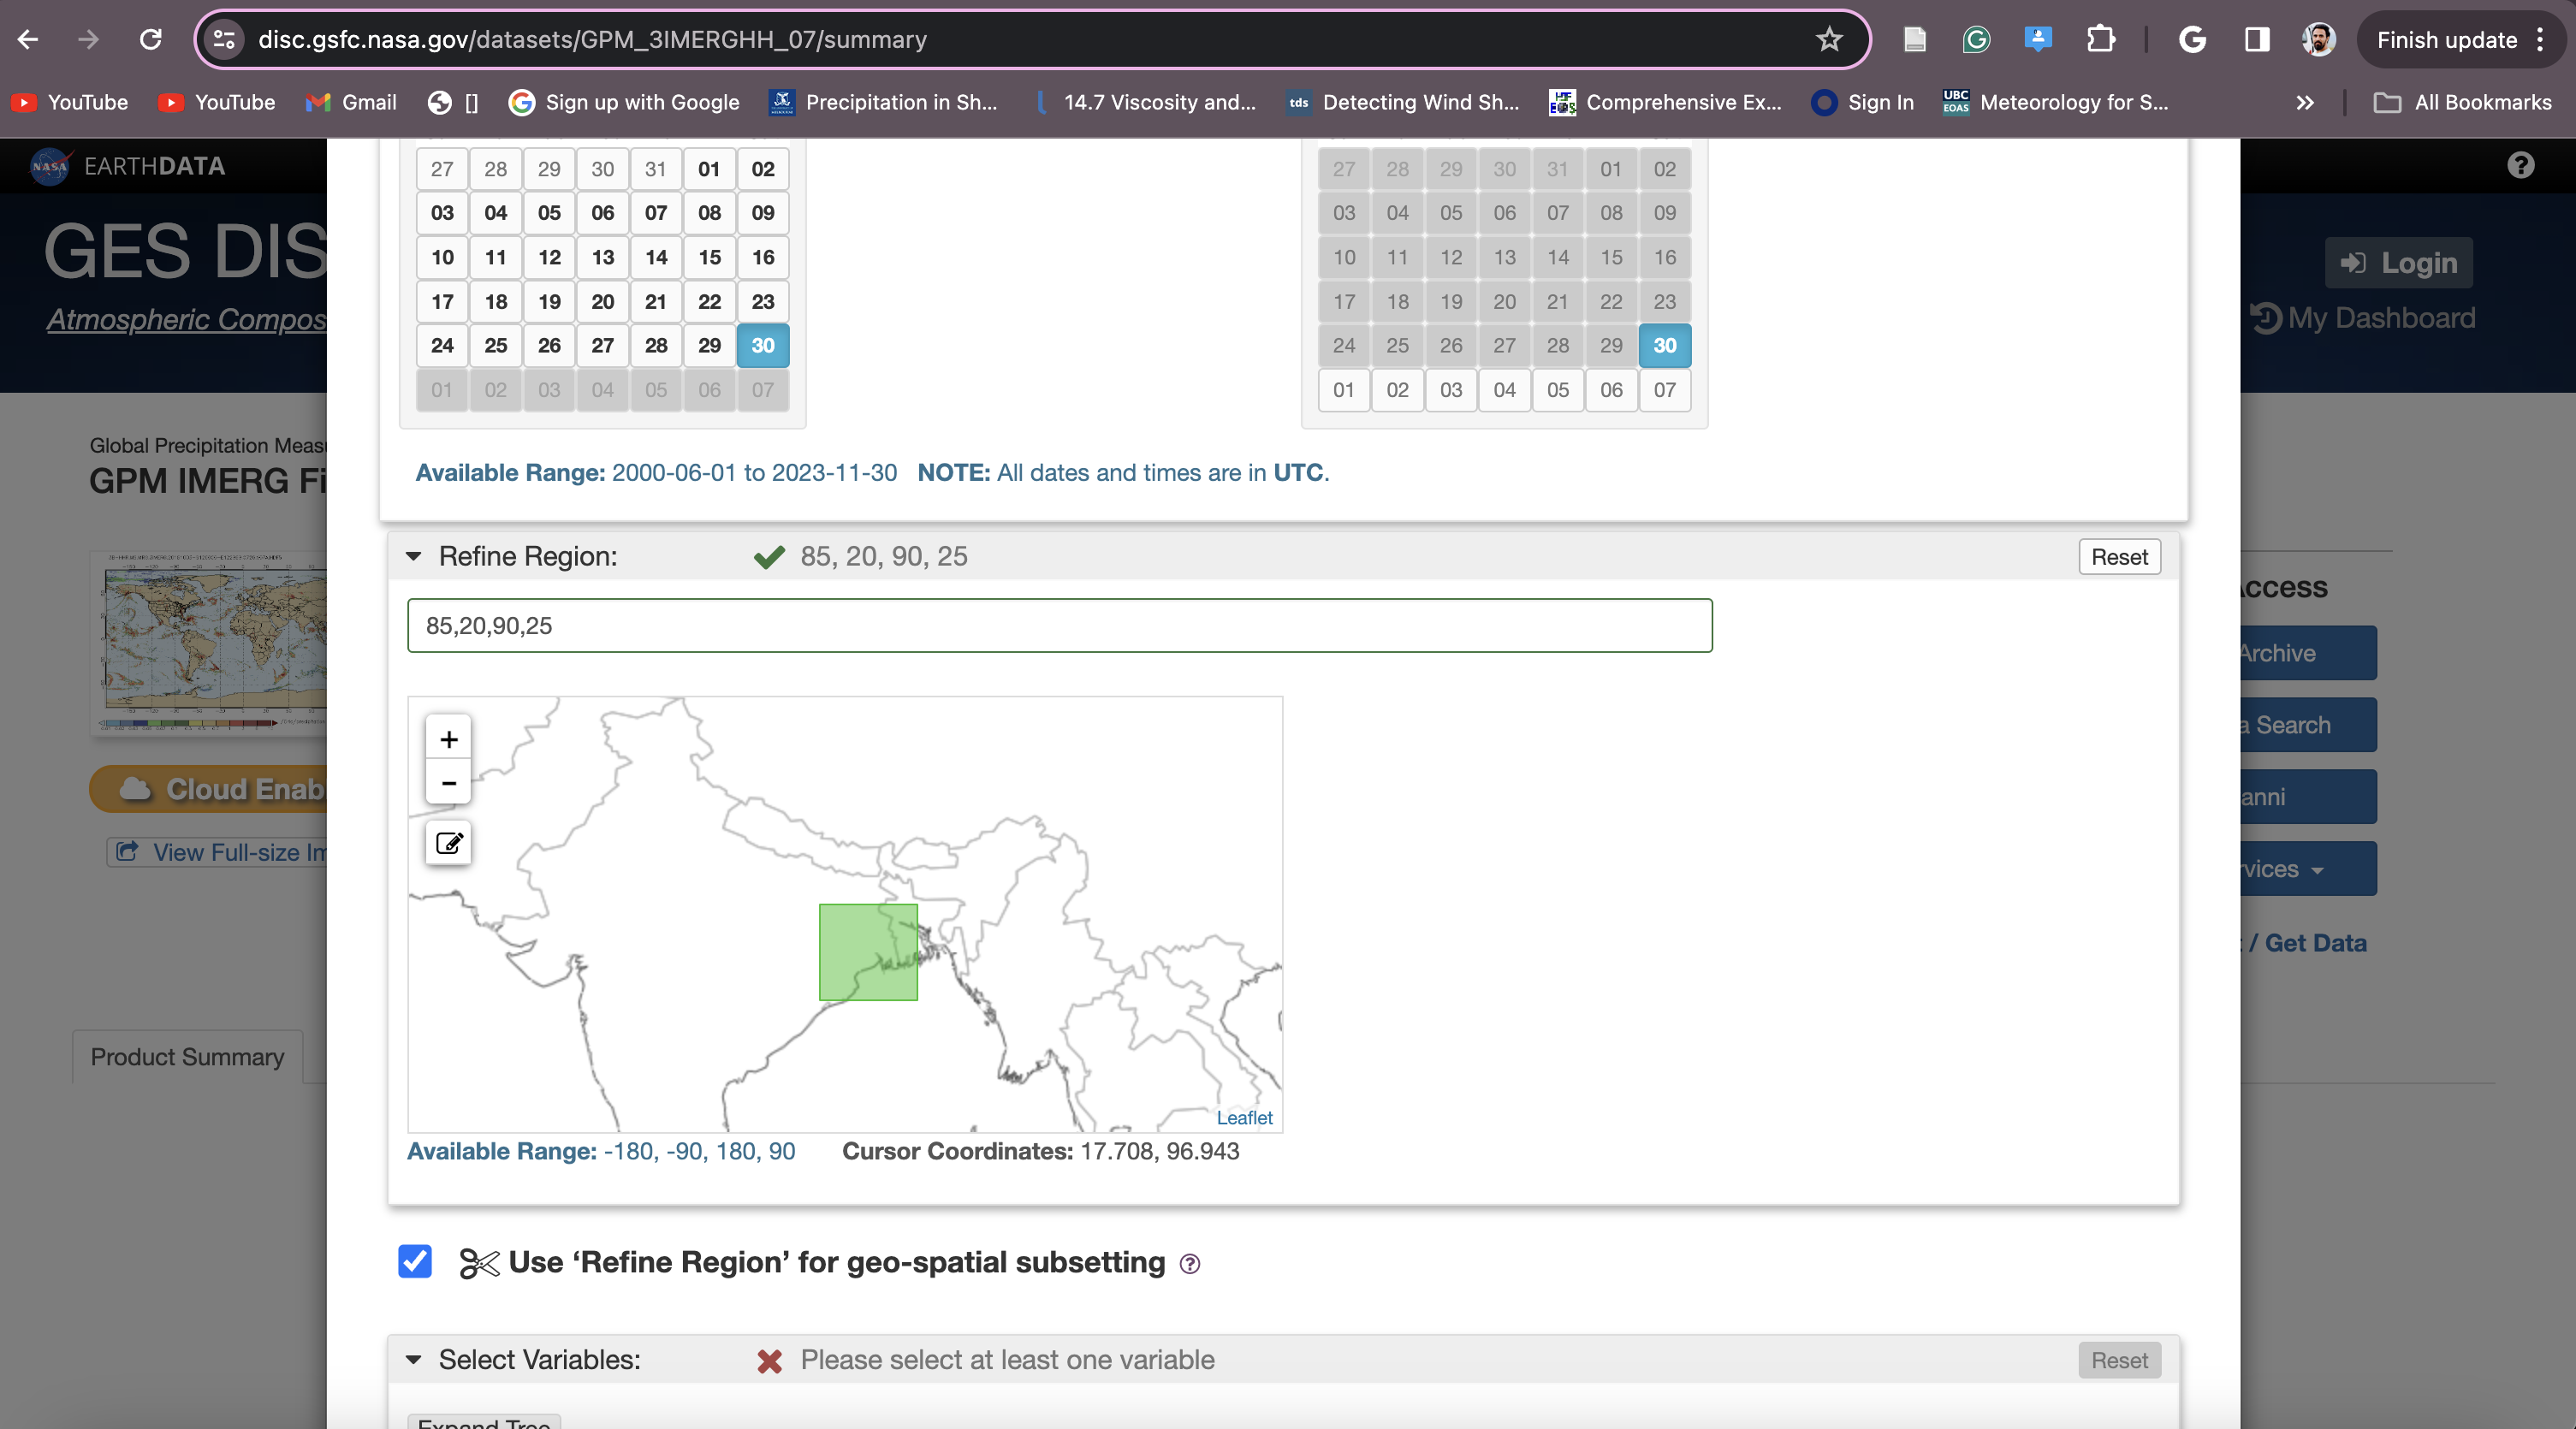

In [17]:
import os
import subprocess
from urllib.parse import quote

def download_imerg_data(url_file, token):
    # Path where the files will be saved
    save_directory = "./IMERG/"
    
    # Ensure the directory exists
    os.makedirs(save_directory, exist_ok=True)
    
    # Read URLs from the specified file
    with open(url_file, 'r') as file:
        urls = file.read().splitlines()
    
    # Loop through each URL and use curl to download the data
    for url in urls:
        # Encode URL to handle special characters, especially for OPeNDAP queries
        encoded_url = quote(url, safe='/:')  # Preserve slashes and colons, encode other characters
        
        # Extract filename from URL
        filename = encoded_url.split('/')[-1].split('?')[0]  # Removing parameters after '?'
        
        # Full path for saving the file
        file_path = os.path.join(save_directory, filename)
        
        # Construct curl command with Authorization header
        curl_command = [
            'curl', '-n',
            '-c', os.path.expanduser('~/.urs_cookies'),
            '-b', os.path.expanduser('~/.urs_cookies'),
            '-H', f'Authorization: Bearer {token}',  # Authorization token header
            '-LJO', '--url', encoded_url,
            '-o', file_path  # Specify output path
        ]
        
        # Execute the curl command
        result = subprocess.run(curl_command, capture_output=True, text=True)
        
        # Check if the download was successful
        if result.returncode == 0:
            print(f'Successfully downloaded {filename}')
        else:
            print(f'Failed to download {filename}. Error: {result.stderr}')

Get you token from here https://urs.earthdata.nasa.gov/profile

In [18]:
imerg_links = "/Users/syed44/Downloads/subset_GPM_3IMERGHH_07_20240426_041913_.txt"

In [19]:
# Example usage
dummy_token = "paste_token_here"  # Replace with your actual token
## uncomment the following line to download data once you have a token and a list of data files
# download_imerg_data(imerg_links, dummy_token)

In [20]:
# !mv *3B*nc4 IMERG

In [21]:
imerg = xr.open_mfdataset("IMERG/*nc4")

In [22]:
imerg['precipitation']

<xarray.DataArray 'precipitation' (time: 48, lon: 51, lat: 51)> Size: 499kB
dask.array<concatenate, shape=(48, 51, 51), dtype=float32, chunksize=(1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 204B 19.95 20.05 20.15 20.25 ... 24.75 24.85 24.95
  * lon      (lon) float32 204B 85.05 85.15 85.25 85.35 ... 89.85 89.95 90.05
  * time     (time) object 384B 2022-04-30 00:00:00 ... 2022-04-30 23:30:00
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    origname:          precipitation
    fullnamepath:      /Grid/precipitation

In [23]:
# Extract the actual datetime values
start_time = ts.time.min().values
end_time = ts.time.max().values

# Use these datetime values directly in the selection
imerg_ts = imerg['precipitation'].mean(['lat', 'lon']).sel(time=slice(str(start_time), str(end_time)))

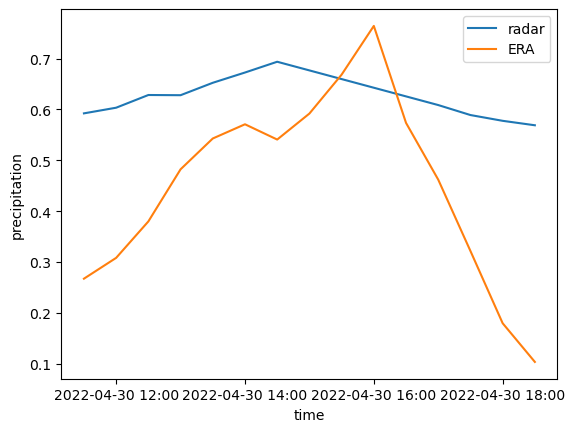

In [24]:
ts.plot(label='radar')
imerg_ts.plot(label='ERA')
plt.legend()

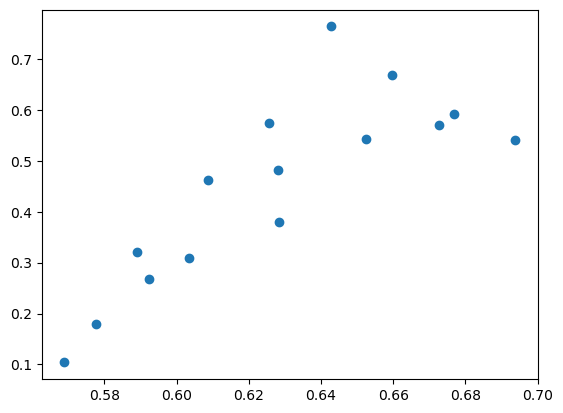

In [25]:
plt.scatter(ts.values, imerg_ts.values)

In [26]:
from scipy.stats import pearsonr

In [27]:
corr, _ = pearsonr(ts.values, imerg_ts.values)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.814
